<a href="https://colab.research.google.com/github/sotha-sil-zen/MCM/blob/main/assignment_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Simulated Annealing on the Travelling Salesman Problem

Given $N$ points on the plane (cities), the *travelling salesman problem* is to find a route that travells through each city exactly once, and returns to the starting point. This is a "classic" problem which is known to be NP-hard, and you can read more about it on [Wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

This has been extensively studied, and there are several well known combinatorial algorithms that yield results close to the optimal path in practical amounts of time. We are going to attempt this problem using simulated annealing to see how well it performs.

In [1]:
%matplotlib inline

import numpy as np, matplotlib as mpl, scipy as sp, scipy.stats as st
from matplotlib import pylab, mlab, pyplot as plt
from matplotlib.pylab import plot, scatter, contour, xlabel, ylabel, title, legend, subplot, fill_between
from matplotlib.animation import FuncAnimation

from numpy import sqrt, pi, exp, log, floor, ceil, sin, cos
from numpy import linspace, logspace, arange, empty, zeros, ones, empty_like, zeros_like, ones_like, full, full_like
from numpy import diff, meshgrid, mean, std, argmin, array, eye, amin, amax, fmin, fmax
from numpy.linalg import norm

from tqdm.notebook import tqdm, trange

plt.rcParams.update({
    'image.cmap': 'coolwarm',
    'animation.html': 'jshtml',
    'animation.embed_limit': 40, # 40 mb
})
rng = np.random.default_rng()

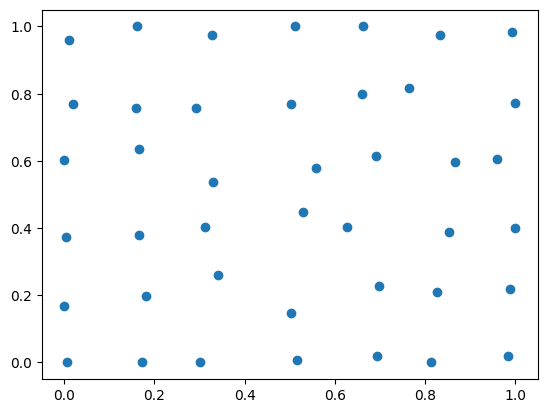

In [2]:
# Generate points randomly
#P = rng.uniform( size=(40, 2) )

# Choose points on a uniform grid, or other special configurations to test.
xx, yy = meshgrid( linspace( 0, 1, num=7 ), linspace( 0, 1, num=6 ) )
P = array( [xx.flatten(), yy.flatten() ] ).T
N = len(P)
P += .025*rng.normal( size=(N, 2) )
P = fmin( fmax( P, 0 ), 1 )

scatter( P[:, 0], P[:, 1] )

## Distribution of the cost of random routes

Before trying anything fancy, let's generate routes randomly, and see what the distribution of the cost looks like. (The cost of a route is just the total length travelled, including the return to the initial point.)

Not surprisingly, they fit on a nice bell curve (shown in orange). We'll note the mean and standard deviation for use later.

  0%|          | 0/100000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Cost of random tours')

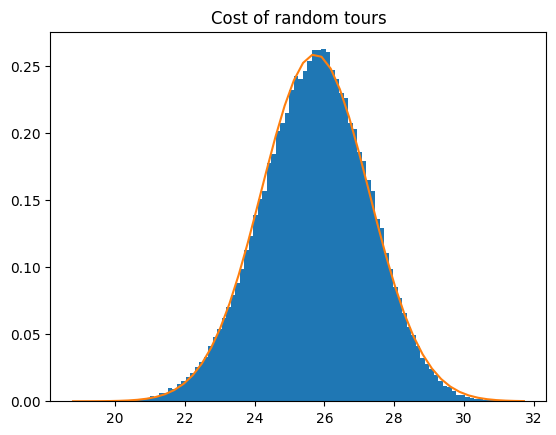

In [3]:
# Check how "typical" short routes are.
cost = lambda P, σ: np.sum( norm( diff( P[np.append( σ, σ[0])], axis=0 ), axis=-1  ) )

Cr = [ cost( P, rng.permutation(N) ) for n in trange( 100000 ) ]

num, bins, _ = plt.hist( Cr, bins=100, density=True )
μ_unif = mean( Cr )
σ_unif = std( Cr )

xx = linspace( bins[0], bins[-1] )
plot( xx, np.sum(num)*(bins[1]-bins[0])*st.norm.pdf( xx, loc=μ_unif, scale=σ_unif ) )

title( 'Cost of random tours' )
#print( f'Get random tours of length < {bins[1]:.2f} about {num[0]/len(Cr)*100:.2g}% of the time' )

## The Greedy nearest neighbour algorithm

Start at a particular point. Travel to the nearest point that hasn't yet been visited.

There are certain scenarios where this algorithm perfoms badly; but in most configurations this gives you a cost that is within 25% of the minimum.

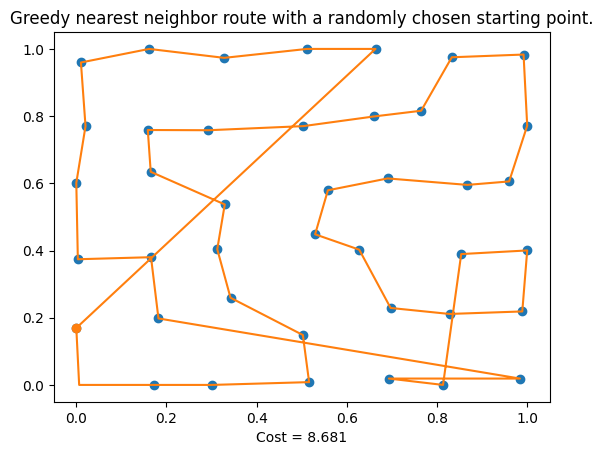

In [4]:
# Greedy algorithm: Just travel to closest available point
def greedy(P, start=None):
    if start is None: start = rng.integers( N )
    σ = [start]
    τ = list( range( N ) )
    del τ[start]

    while τ:
        n = argmin( norm( P[τ] - P[σ[-1]], axis=-1 ) )
        σ.append( τ[n] )
        del τ[n]

    return σ

def draw_tour( P, σ, firstPointStyle='C1o', **kwargs ):
    τ = np.append( σ, σ[0] )
    plot( P[τ[0], 0], P[τ[0], 1], firstPointStyle )
    #for n in range( len(σ) ):
    #    arrow( *P[τ[n]], *(P[τ[n+1]] - P[τ[n]]), head_width=.015,
    #          length_includes_head=True, **kwargs )
    plot( P[τ, 0], P[τ, 1], **kwargs )

σG = greedy(P)
scatter( P[1:, 0], P[1:, 1] )
draw_tour( P, σG, color='C1' )
_=title( f'Greedy nearest neighbor route with a randomly chosen starting point.' )
_=xlabel( f'Cost = {cost( P, σG):.3f}' )


### Minimizing over the starting point

The nearest neighbor route depends on the point you start at. It's easy to minimize over all starting points, so let's do that first.

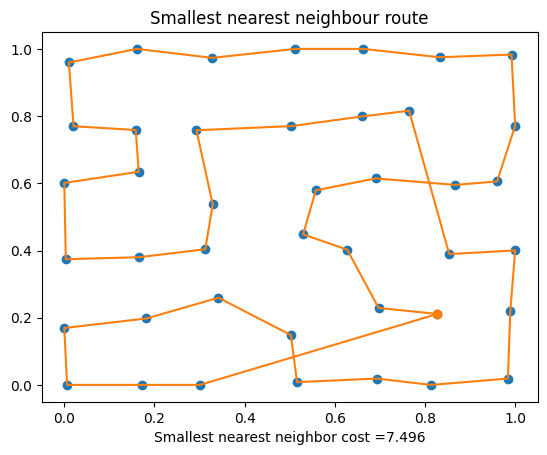

In [5]:
# Find best starting point for Greedy
s0 = argmin( [cost( P, greedy( P, start=n ) ) for n in range(N) ] )
σs0 = greedy( P, start=s0 )

scatter( P[:,0], P[:, 1] )
draw_tour( P, σs0, color='C1' )

_=xlabel( f'Smallest nearest neighbor cost ={cost(P, σs0):.3f}' )
_=title( 'Smallest nearest neighbour route' )

## Simulated Annealing

Let's use simulated annealing and our improvement procedure together:

* Choose the temperature after the $n$-th iteration according to some schedule. ($T_0$ should be large, $T_{\text{final}}$ should be very small).
* Use Metropolis Hastings to sample from the distribution proportional to $π_u(\sigma) \propto e^{-C(\sigma)/T_n}$.
    - Here $\sigma$ is a permutation of the points (describing the route taken by the salesman).
    - $C(\sigma)$ is the total length (cost) of the route
* Explictly, do the following:
    - After $n$ iterations suppose we have a route $\sigma_n$.
    - Come up with a reasonable proposal mechanism to generate $\sigma_n'$ from $\sigma_n$. (There are more than one proposal mechanisms that work well. If you're getting bad results, try something different.)
    - Accept / reject $\sigma_n'$ as the Metropolis Hastings algorithm dictates in order to sample from $π_u(\sigma) \propto e^{-C(\sigma)/T_n}$.
* To improve our odds, we'll also run many realizations of this:
    - Given $\sigma_0$, instead of generating just $1$ new route $\sigma_0'$, we will generate $N_\text{reals}$ new routes $\sigma_1$'s.
    - Each new route $\sigma_0'$ is accepted / rejected as above
    - This procedure is continued indepndently for all realizations.


### Question 1
Define a function `anneal` that does the following:

```python
    
    
def anneal( P, σ0, TT ):
    # P = points, σ0 = array of initial tours, TT = annealing temperature schedule
    # TT is an array of temperatures with TT[0] large and TT[-1] small.
    N = len(P)
    n_iters = len(TT)
    n_reals = σ0.shape[0]
    C = empty( (n_reals, n_iters) )

    σ = σ0.copy()
    Cσ = array( [cost( P, σ[k] ) for k in range(n_reals)] )

    for n, T in enumerate( TT ):
        τ = σ.copy()
        for k in range(n_reals):
            new_order = np.copy(σ[k])
            rnd_idx = np.random.randint(len(σ[k]),size=2)
            i, j = rnd_idx[0], rnd_idx[1]
            new_order[i], new_order[j] = new_order[j], new_order[i]
            new_cost=cost(P, new_order)

            logπu_old=-Cσ[k]/T
            logπu_new=-new_cost/T


            logπu_div=logπu_new-logπu_now

            log_uni=np.log(np.random.uniform(1e-10,1.,len(v_vals)))

            if (new_cost < Cσ[k]) or (logπu_div>log_uni):
                σ[k] = new_order
                Cσ[k] = new_cost
            # Remember that σ is an array of n_reals tours.
            # σ[k] is the k-th tour
            # Propose a new tour, and accept it according to Metropolis Hastings
            # If you accept the new tour, update Cσ[k] = cost( P, new_tour )

        C[:, n] = Cσ # Store the cost of the tour at time n

    return σ, C
```

In [15]:


def anneal( P, σ0, TT ):
    # P = points, σ0 = array of initial tours, TT = annealing temperature schedule
    # TT is an array of temperatures with TT[0] large and TT[-1] small.
    N = len(P)
    n_iters = len(TT)
    n_reals = σ0.shape[0]
    C = empty( (n_reals, n_iters) )

    σ = σ0.copy()
    Cσ = array( [cost( P, σ[k] ) for k in range(n_reals)] )

    for n, T in enumerate( TT ):
        τ = σ.copy()
        for k in range(n_reals):
            new_order = np.copy(σ[k])
            rnd_idx = np.random.randint(len(σ[k]),size=2)
            i, j = rnd_idx[0], rnd_idx[1]
            new_order[i], new_order[j] = new_order[j], new_order[i]
            new_cost=cost(P, new_order)

            logπu_now=-Cσ[k]/T
            logπu_new=-new_cost/T


            logπu_div=logπu_new-logπu_now

            log_uni=np.log(np.random.uniform(1e-10,1.))

            if (new_cost < Cσ[k]) or (logπu_div>log_uni):
                σ[k] = new_order
                Cσ[k] = new_cost
            # Remember that σ is an array of n_reals tours.
            # σ[k] is the k-th tour
            # Propose a new tour, and accept it according to Metropolis Hastings
            # If you accept the new tour, update Cσ[k] = cost( P, new_tour )

        C[:, n] = Cσ # Store the cost of the tour at time n

    return σ, C

In [10]:
# Plots results. Shows cost of tours, and the tours themselves side by side
def figsize( sizex, sizey ):
    plt.rcParams['figure.figsize'] = [sizex, sizey]

def show_results( σ, C ):
    (n_reals, n_iters) = C.shape
    nn = arange( n_iters )
    n_min = argmin( C[:, -1] ) # best tour

    figsize( 12, 4 )
    subplot( 1, 2, 1 )

    plot( nn, C[n_min], label='Minimum' ) # Cost for best tour

    for n in rng.choice( n_reals, replace=False, size=5 ):
        plot( nn, C[n], color='C1', alpha=.5 ) # Cost for a few random tours

    μ = mean( C, axis=0 )
    σμ = std( C, axis = 0 )

    plot( nn, μ, color='C2', label='Average' ) # Average cost of all tours
    fill_between( nn, μ-σμ, μ+σμ, alpha=.2, color='C2' )
    xlabel( '# Iterations' )
    ylabel( 'Cost' )

    title( f'Cost of varous tours (Minimum: {amin(C):.3f})' )

    subplot( 1, 2, 2 )
    title( 'Few locally optimal tours (global in solid)' )
    scatter( P[:, 0], P[:, 1] )

    for k, n in enumerate( rng.choice( n_reals, replace=False, size=5 ) ):
        draw_tour( P, σ[n], firstPointStyle=f'C{k}o', color=f'C{k}', alpha=.5, linestyle='--' )
    draw_tour( P, σ[n_min]  )

    figsize( 6, 4 )

### Choosing the starting point

Experiment around and see what works best.
* Could start with a random route, and see whether or not simulated annealing beats the nearest neighbor
* Could start with a nearest neighbor route
* Could start with the smallest nearest neighbor route.

For now, let's start with the smallest nearest neighbor route, and see how much simulated annealing improves it.

In [11]:
# Choose starting point
#σ0 = array( [greedy(P) for n in range(100)] ) # Greedy with random starting point
σ0 = array( [σs0 for n in range(100) ] ) # Greedy with starting point that minimises cost
#σ0 = array( [ rng.permutation(N) for n in range(100) ] )

### Choosing the annealing schedule (temperature)
* How fast should you decrease the temperature from $T_0$ to $T_{\text{final}}$?
* How large / small should you choose $T_0$ and $T_{\text{final}}$?

A good rule of thumb is to let $T$ decrease slower as it becomes smaller.

  0%|          | 0/10000 [00:00<?, ?it/s]

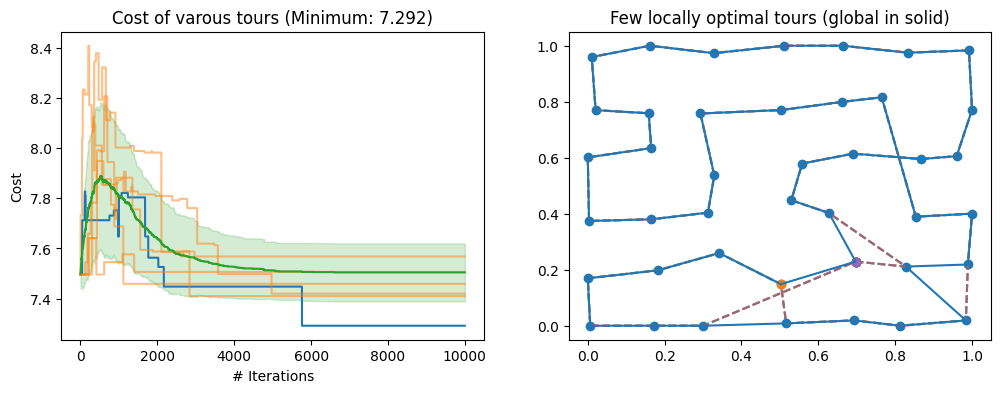

In [16]:
TT1 = logspace( -1, -5, num=10000 )

(σ, C) = anneal( P, σ0, tqdm( TT1 ) )

show_results( σ, C )

#### Differnt annealing schedule

Let's vary the temperature range so we start at a hotter temperature and see if this changes anything. (There's no rule of thumb to choose the temperature range; one has to experiment around. This choice typically makes things worse than the previous one.)

  0%|          | 0/10000 [00:00<?, ?it/s]

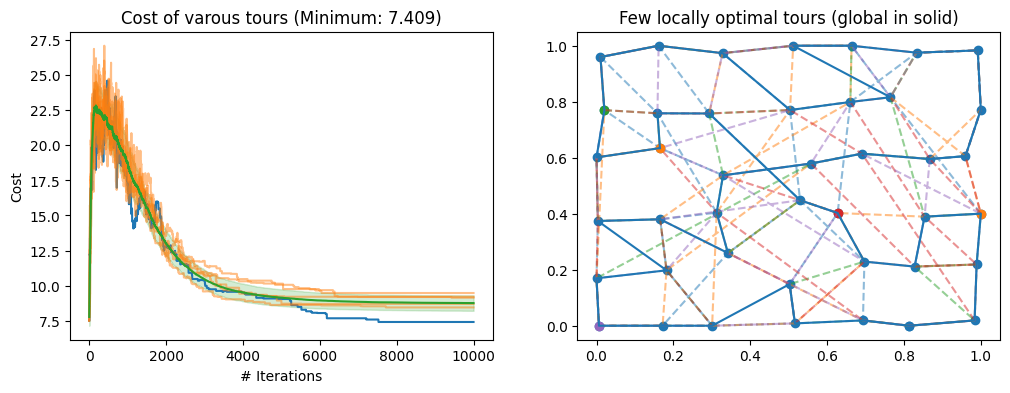

In [17]:
TT2 = logspace( 0, -5, num=len(TT1) )

# Different annealing schedule
(σ1, C1) = anneal( P, σ0, tqdm( TT2 ) )
show_results( σ1, C1 )

#### No Annealing.

Without annealing, we only accept new routes if they reduce the total cost. Rather than coding this separately, we'll just use our anneal function with the temperature set to something that's extremely small. Most final routes obtained this way are the same, and are a bit more expensive than our first attempt with annealing. (This might vary on the configuration of points initially, of course.)

  0%|          | 0/10000 [00:00<?, ?it/s]

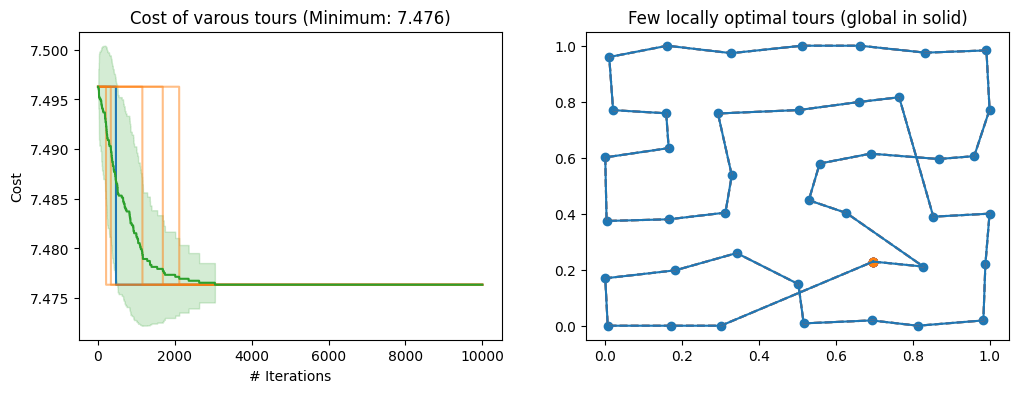

In [18]:
# No annealing (by setting temperature to something super small)
(σ2, C2) = anneal( P, σ0, tqdm( full( len(TT1), 1e-20 ) ) )
show_results( σ2, C2 )

### How well did we do?

We saw before that the distribution of the cost of randomly chosen routes is a Gaussian, with a mean and variance we stored. What is the probability of obtaining one of the minimizers above by random chance? The exact number is below, but it's usually around $10^{-33}$.

In [19]:
print( f'Chance of finding a tour of length at most {amin(C):.2f} ≈ '
    f'{st.norm.cdf( amin(C), loc=μ_unif, scale=σ_unif ):.3g}' )

Chance of finding a tour of length at most 7.29 ≈ 2.95e-33


How small is this? In order to have a reasonable chance of randomly seeing one of these, I would have to run about $10^{33}$ iterations. On my computer I can generate about 100,000 ranom routes a second. If I switched to a faster computer, and faster language let's say this improves to one billion. The universe is only around $10^{19}$ seconds old. So I would have to run my program for $10,000$ times the life of the universe in order to have a reasonable chance of randomly seeing one of these routes.